In [1]:
from pylab import *
import numpy as np

# Homework 3: ISM Dynamics


## Part I: 3-phase SNR remnant model
We're going to construct a three phase supernova remnant model based on what we learned in class, solving for the radius and velocity of the remnant front and then use it ask questions about ISM dynamics
Below is the a `SN` class object initialized based on the initial supernova energy, the mass ejected, and the ambient conditions of the interstellar medium. Looking at the `__init__` function, you should see that we are initializing an array in time and will be filling in arrays of the shock front velocity and the shock front radius that correspond to those times. 
Each phase of the supernova expansion has a solution for the front velocity and the front radius and a corresponding condition at which the phase ends. For each phase, we will write a function that solves for the velocity, radius, and corresponding limit over which the solutions apply, filling in the array when that condition is met. Each solution needs to be properly normalized so that it matches its value at the end of the previous phase. 

As an example for what the function should do, the `free_expansion` phase function has been written for you. Note that the function fills the appropriate solution for `v_f` in units of $km/s$, `R_f` in units of $pc$ for the range of indices `imin` to `imax` over which the solution is valid. The index of the transition point is then stored so that it can be used to define `imin` for the subsequent function.

### a. 
Fill in the function for the energy conserving phase as the `blast_wave` function. Recall that the condition for the end of the energy conserving phase is when the post-shock temperature $T < 10^6 \mathrm{K}$. 

### b. 
Fill in the function for the momentum conserving phase as the `snow_plow` function. Recall that the condition for the end of the momentum conserving phase occurs when the velocity is on par with the ambient sound speed. 

In [2]:
Msun = 1.99e33 #mass of sun in grams
cmtokm = 1e-5 #conversion from cm to km
yrtos = 3.154e7 #seconds in year
mH = 1.67e-24 #mass of a hydrogen atom in grams
pctocm = 3.086e18 #cm in a parsec

class SN:
    def __init__(self,E0=10**51, M0=1.0, rho_amb=1*mH,T_amb=100.):
        self.E0 = E0
        self.v0 = np.sqrt(2.*E0/(M0*Msun)) #velocity of ejecta in cm/s
        self.M0 = M0*Msun # mass of the ejecta
        self.time = np.logspace(-1,9,100,dtype='float') #time in yrs
        self.v_f = np.zeros_like(self.time) #empty arrays for the velocity of the front over time, units of km/s
        self.R_f = np.zeros_like(self.time) #empty arrays for the radius of the front over time, units of pc
        self.rho_amb = rho_amb #ambient medium density in g/cm^3
        self.i_bc = [0,0,0] # to record the index of the arrays at which each phase ends
        self.cs_amb = 0.3*np.sqrt(T_amb/10.) # ambient sound speed in km/s
        
    def free_expansion(self):
        imin = 0 #index of the start of the phase
        v_free = self.v0*np.ones_like(self.time)
        r_free = v_free*self.time*yrtos
        r_lim = (3*self.M0/4./pi/self.rho_amb)**(1./3.)
        imax = np.argmin(np.abs(r_free-r_lim)) # index of the end of the phase
        self.v_f[imin:imax] = v_free[imin:imax]*cmtokm #in km/s
        self.R_f[imin:imax] = r_free[imin:imax]/pctocm #in pc
        self.i_bc[0] = imax-1 #record transition point
        
    def blast_wave(self):
        imin = self.i_bc[0]
        #your function here
        
        rho_blast = 4 * self.rho_amb
        # need energy at end of free expansion to conserve boundary 
        E_fe = 1/2 * (rho_blast * (4/3) * np.pi * (self.R_f[imin] * pctocm) **3 ) * (self.v_f[imin]/cmtokm)**2
        
        # calculate R_scale at end of t_fe and beginning of t_bw
        R_scale = self.R_f[imin] / ((E_fe / self.rho_amb)**(1/5) * (self.time[imin] * yrtos)**(2/5))
        
        r_bw = R_scale * (self.E0 / self.rho_amb)**(1/5) * (yrtos * self.time)**(2/5) * pctocm  # in cm
        m_bw = rho_blast * (4/3) * np.pi * (r_bw)**3 # in grams
        v_bw = (2 * self.E0 / m_bw)**(0.5) # in cm / s 
        T2 = 2e9 * (v_bw * cmtokm / 1e4)**2 # in K
        
        imax = np.where(T2 <= 1e6)[0][0] # boundary condition

        self.v_f[imin:imax] = v_bw[imin:imax]*cmtokm
        self.R_f[imin:imax] = r_bw[imin:imax]/pctocm
        self.i_bc[1] = imax-1
        
    def snow_plow(self):
        imin = self.i_bc[1]
        #your function here 
        r_bw = self.R_f[imin] # in pc
        v_bw = self.v_f[imin] # in km / s 
        
        p = self.rho_amb * (r_bw * pctocm)**3 * (v_bw/cmtokm) # constant 
        
        # need to boundary condition at time[imin]
        r_sp = r_bw * (self.time / self.time[imin])**(1/4)
        v_sp = v_bw * (self.time / self.time[imin])**(-3/4)
        
        imax = np.where(v_sp <= self.cs_amb)[0][0] # boundary condition

        self.v_f[imin:imax] = v_sp[imin:imax]
        self.R_f[imin:imax] = r_sp[imin:imax]
        self.i_bc[2] = imax-1


### part c.
When you're happy with the solutions you've developed, run your model for the default choice of input parameters. Plot the solution and label the three phases of the solution. 

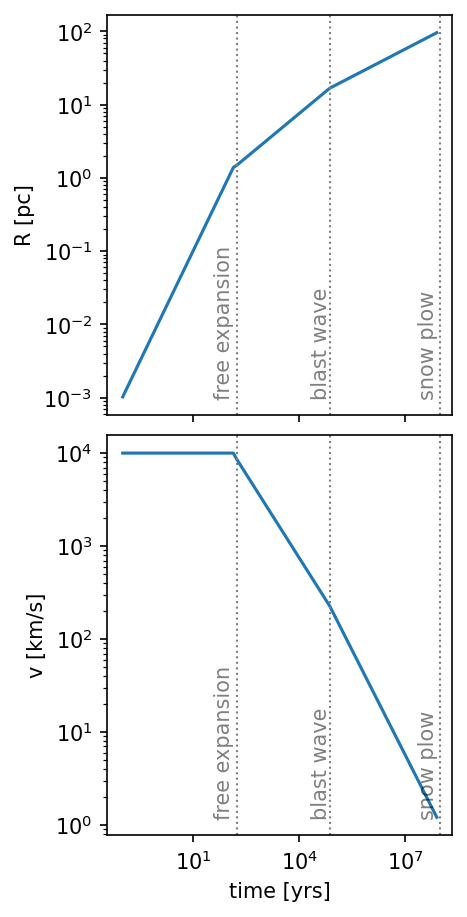

In [3]:
snr = SN()
snr.free_expansion()
snr.blast_wave()
snr.snow_plow()

f,ax=subplots(2,constrained_layout=True, dpi=150,sharex=True)
f.set_size_inches(3,6)
ax[0].loglog(snr.time[:snr.i_bc[2]],snr.R_f[:snr.i_bc[2]])
ax[1].loglog(snr.time[:snr.i_bc[2]],snr.v_f[:snr.i_bc[2]])
ax[1].set_xlabel('time [yrs]')
ax[0].set_ylabel('R [pc]')
ax[1].set_ylabel('v [km/s]')

for a in ax:
    a.axvline(snr.time[snr.i_bc[0]],color='gray',ls='dotted',lw=1)
    a.annotate('free expansion', xy=(0.31, 0.05), rotation=90, xycoords='axes fraction', alpha=0.5)
    a.axvline(snr.time[snr.i_bc[1]],color='gray',ls='dotted',lw=1)
    a.annotate('blast wave', xy=(0.59, 0.05), rotation=90, xycoords='axes fraction', alpha=0.5)
    a.axvline(snr.time[snr.i_bc[2]],color='gray',ls='dotted',lw=1)
    a.annotate('snow plow', xy=(0.9, 0.05), rotation=90, xycoords='axes fraction', alpha=0.5)

### part d.
Run the remnant model for three different types of ISM conditions and plot them all on the same plot.
1. Warm Neutral Medium
2. Cold Neutral Medium
3. Molecular Cloud 

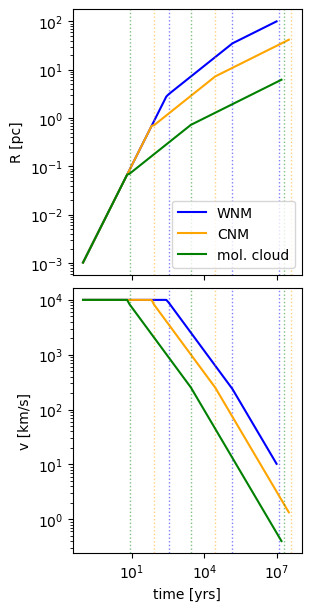

In [4]:
f,ax=subplots(2,constrained_layout=True, dpi=100,sharex=True)
f.set_size_inches(3,6)
ax[1].set_xlabel('time [yrs]')
ax[0].set_ylabel('R [pc]')
ax[1].set_ylabel('v [km/s]')

rho_WNM = mH * 0.1 # cm^-3 
T_WNM = 8000 # K
rho_CNM= mH * 10 # cm^-3  
T_CNM= 100 # K 
rho_mol= mH * 1e4 # cm-3
T_mol = 10
cond1 = {'rho_amb': rho_WNM, 'T_amb': T_WNM,'label':'WNM', 'c':'blue'}
cond2 = {'rho_amb': rho_CNM, 'T_amb': T_CNM,'label':'CNM', 'c':'orange'}
cond3 = {'rho_amb': rho_mol, 'T_amb': T_mol, 'label':'mol. cloud', 'c':'green'}

for cond in [cond1,cond2,cond3]:
    snr = SN(rho_amb=cond['rho_amb'],T_amb=cond['T_amb'])
    snr.free_expansion()
    snr.blast_wave()
    snr.snow_plow()

    ax[0].loglog(snr.time[:snr.i_bc[2]],snr.R_f[:snr.i_bc[2]], label=cond['label'], c=cond['c'])
    ax[1].loglog(snr.time[:snr.i_bc[2]],snr.v_f[:snr.i_bc[2]], label=cond['label'], c=cond['c'])
    [ax[0].axvline(snr.time[snr.i_bc[i]],color='gray',ls='dotted',lw=1, alpha=0.5, c=cond['c']) for i in range(3)]
    [ax[1].axvline(snr.time[snr.i_bc[i]],color='gray',ls='dotted',lw=1, alpha=0.5, c=cond['c']) for i in range(3)]
    
ax[0].legend()



<font color='purple'>
Describe the main differences across these these different environments in terms of the remnant properties. In terms of the basic understanding of shocks we built up in class, why does this behavior hold?</font>

A supernova remnant will grow larger in the WNM environment (less dense environment) than a molecular cloud environment (very dense environment). It also appears that a supernova in a molecular cloud spends the longest time in the snow plow phase and the shortest time in the free expansion phase, the opposite for a WNM. 

### part e.

Now run the remnant model but varying the progenitor mass. Make a similar plot.

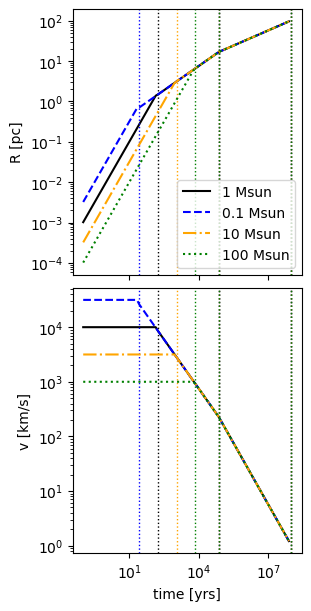

In [5]:
f,ax=subplots(2,constrained_layout=True, dpi=100,sharex=True)
f.set_size_inches(3,6)
ax[1].set_xlabel('time [yrs]')
ax[0].set_ylabel('R [pc]')
ax[1].set_ylabel('v [km/s]')


cond1 = {'M0': 0.1, 'label': '0.1 Msun', 'ls': '--', 'c':'blue'}
cond2 = {'M0': 1, 'label': '1 Msun', 'ls': '-', 'c':'black'}
cond3 = {'M0': 10, 'label': '10 Msun', 'ls': '-.', 'c':'orange'}
cond4 = {'M0': 100, 'label': '100 Msun', 'ls': ':', 'c':'green'}

for cond in [cond2, cond1,cond3, cond4]:
   snr = SN(M0 = cond['M0'])
   snr.free_expansion()
   snr.blast_wave()
   snr.snow_plow()

   ax[0].loglog(snr.time[:snr.i_bc[2]],snr.R_f[:snr.i_bc[2]], label=cond['label'], ls=cond['ls'], c=cond['c'])
   [ax[0].axvline(snr.time[snr.i_bc[i]],color='gray',ls='dotted',lw=1, c=cond['c']) for i in range(3)]
   ax[1].loglog(snr.time[:snr.i_bc[2]],snr.v_f[:snr.i_bc[2]], label=cond['label'], ls=cond['ls'], c=cond['c'])
   [ax[1].axvline(snr.time[snr.i_bc[i]],color='gray',ls='dotted',lw=1, c=cond['c']) for i in range(3)]
    
ax[0].legend()


<font color='purple'>Based on the plot, what is more important for determining the remnant properties, the supernova progenitor's environment or the supernova progenitor's properties?</font>

Based on the plot, it appears that the supernova progenitor environment is more important than the supernova progentior properties for determining the remnant properties.

## Part II: Thinking about Turbulence

We talked pretty generally about ways we can generate turbulence in the ISM. Today we're going to think about how turbulence is quantified.

In the standard fluid dynamical picture, a flow is judged to be turbulent by the ratio of its inertial forces to its viscous ones. Fluid viscosity usually refers to the amount of intramolecular friction a fluid has, which is a behavior that is dependent on the fluid composition but also it's temperature and density. The more viscous a fluid is the more it damps out fluctuations that could become grow to become turbulent, so it generally moves more smoothly (a.k.a. as a laminar flow) at the same amount of agitation e.g. think how easy it is to create ripples and frothing in water by stirring vs in honey. 

The ratio of inertial forces to viscous ones is defined as the Reynolds Number $Re$, which you can derive by taking the ratio of the advection forces in the momentum equation to the viscous ones. Simplified by dimensional analysis, it is usually evaluated as a characteristic fluid velocity $u$, a characteristic length scale $R$, and the kinematic viscosity $\nu$. 

$Re = \frac{\mathrm{Inertial \ Forces}}{\mathrm{Viscous \ Forces}} = \frac{\rho u \cdot \nabla u}{\rho \nu \nabla^2 u} \sim \frac{u R}{\nu}$

When $Re \gtrsim 5000-10000$, the flow is considered turbulent.

The kinematic viscosity then has units of $v \times L$, which is often considered to encode the velocity of the smallest fluctuations times the length scale of the mean free-path $\lambda = 1/n\sigma$ between molecules. Where $n$ is the number density of atoms and $\sigma$ is the interaction cross-section. 

or: 

$\nu = \frac{u_t}{n \sigma}$

where estimates will say that $u_t = c_s$ is the velocity of fluctuations at the smallest scales i.e. the sound speed and $n$ is the number density of hydrogen atoms, and $\sigma = 10^{-15} cm^{2}$, which the area of an atom (e.g. the Bohr radius is $\sim 10^{-8} cm$.) 

### part a.

Define a function to calculate the Reynold's number for a flow given a characteristic flow velocity, characteristic flow length scale, temperature, and density.


In [6]:
def Re(u, R, T, rho):
    # u is in km / s
    # R is in pc 
    # T is in K 
    # rho is in g / cm^-3 
    
    sigma = 1e-15 # cm^2
    k_B = 1.3807e-16 # cm^2 g s^-2 K^-1
    mH = 1.67e-24 # g to kg
    gamma = 5/3
    
    nH = rho / mH # cm^-3 
    c_s = (gamma * k_B * T / mH)**(1/2)
    
    nu = c_s / (nH * sigma)
    
    #your function here
    return (u * 1e3 * 1e2) * (R * pctocm) / nu 

### part b.

Typically, the characteristic velocity and length scales are considered to be the characteristic scales of the flow -- the scales at most of the energy is being injected.
For example, shear flow is the most common system for looking at turbulence generation, where one side of the flow is slower than the other side of the flow and fluctuations build up at the boundary (for a physical picture, think of how airplane turbulence forms at the surface of the wing of the plane where it cuts through the incoming air, or at pipe edges where it is being slowed down by friction with the pipe surface). For a pipe, for example, the characteristic velocity is the average flow speed and the characteristic length is the pipe radius. 

(There are many nice fluid dynamical resources online for building intuition about this, which would make good resource contributions for anyone who wants to write about them)

Anyway, in our toy model, we're going to try to see what the Reynold's numbers are like for different types of assumptions regarding the scale and physical conditions of our flow. 
Using your function in part a, plot the Reynolds number as a function of length scale (let's say from 0.01 to 100 pc). Take the characteristic velocity to be the velocities measured by Larson's Law as a function of length scale. 

Plot this for :
1. WNM density and temperature conditions
2. CNM density and temperature conditions

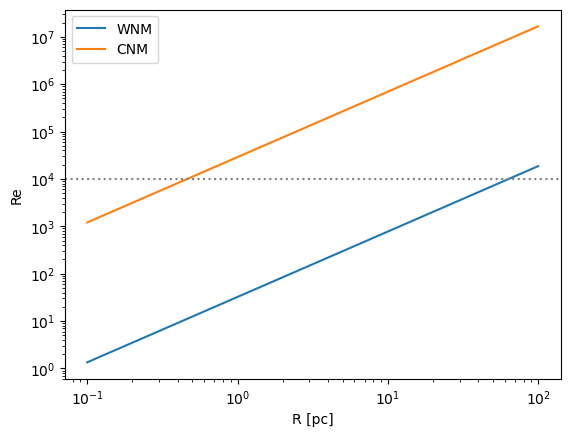

In [7]:
fig, ax = plt.subplots()
L = np.logspace(-1,2,100)
u_LL = 1.1 * L**(0.38) # Larson's law
loglog(L, Re(u_LL,L,T_WNM,rho_WNM),label='WNM')
loglog(L, Re(u_LL,L,T_CNM,rho_CNM),label='CNM')
axhline(1e4,color='gray',ls='dotted')
xlabel("R [pc]")
ylabel('Re')
legend()

<font color='purple'>
According to this plot, for a threshold Reynolds number of 10000, what is the corresponding length scale for turbulent energy injection for each phase in order to reproduce observed velocity dispersions?</font>

The corresponding length scales for tubulent energy injection in each phase to reproduce velocity disperion observations are $\sim 50 \ {\rm pc}$ for the WNM and $\sim 0.5 \ {\rm pc}$ for the CNM.


<font color='purple'>
Does a hotter medium require shear on a larger or smaller scale than a colder medium?</font>

A hotter medium requires sheer on a larger scale than a colder medium.